<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

_While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing._

In [1]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [2]:
# general python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as dafButler

# LSST package for image display
import lsst.afw.display as afwDisplay

from matplotlib import colormaps



### 1.2 Define Functions and Parameters

Import some functions from Pedro

In [3]:
import numpy as np 
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq
#Constants

A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

#values taken from sbpy for convenience

alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2, 3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2, 1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1, 1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]


phi_1 = CubicSpline(alpha_12, phi_1_sp, bc_type=((1,phi_1_derivs[0]),(1,phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp, bc_type=((1,phi_2_derivs[0]),(1,phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp, bc_type=((1,phi_3_derivs[0]),(1,phi_3_derivs[1])))


def HG_model(phase, params):
    """
    Reference: Bowell et al. (1989)
    This is the oldest 2 parameter model. 
    """
    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)
    
    W = np.exp(-90.56 * tan_ah * tan_ah)    
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)
    
    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina
    
    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))
    
    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L
    return params[0] - 2.5*np.log10((1-params[1])* phi_1 + (params[1]) * phi_2) 



def HG1G2_model(phase, params):
    """
    Reference: Muinonen et al. (2010) https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract
    This is the 3 parameter model, which works best when you have a sufficiently long phaseangle coverage.
    """

    tan_ah = np.tan(phase/2)

    phi_1_ev = phi_1(phase)  
    phi_2_ev = phi_2(phase)  
    phi_3_ev = phi_3(phase)  

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6*phase[msk]/np.pi 
    phi_2_ev[msk] = 1- 9 * phase[msk]/(5*np.pi)

    phi_3_ev[phase > np.pi/6] = 0

    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev + params[2] * phi_2_ev + (1-params[1]-params[2]) * phi_3_ev)


def HG12_model(phase, params): 
    """
    Reference:
    Muinonen et al. (2010) https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract
    This is a simplified version of HG1G2. It's more useful when phaseangle coverage is shorter.
    """
    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162 
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164  
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])


def chi2(params, mag, phase, mag_err, model):
    pred = model(phase, params)
    return (mag - pred)/mag_err


def fit(mag, phase, sigma, model=HG12_model, params=[0.1]):
    phase = np.deg2rad(phase)

    sol = leastsq(chi2, [mag[0]] + params,  (mag, phase, sigma, model), full_output = True)

    return sol

In [4]:
def fit_models(mag, magSigma, phaseAngle, tdist, rdist, verbose=False):

    # correct the mag to 1AU distance
    dmag = -5. * np.log10(tdist*rdist)
    mag = mag + dmag

    #double check if this is needed
    #phaseAngle = np.deg2rad(phaseAngle)

    # now we'll fit using each one of the HG, HG12 and HG1G2 models and store these in a dictionary of dictionaries
    solutions = {}

    #Let's do HG first
    sol_HG = fit(mag, phaseAngle, magSigma, model=HG_model)

    solutions['HG'] = {}
    # save np.nan values when the fit has not been converged
    try:
        solutions['HG']['chi2'] = np.sum(sol_HG[2]['fvec']**2)
        solutions['HG']['H'] = sol_HG[0][0]
        solutions['HG']['G'] = sol_HG[0][1]
        solutions['HG']['H_err'] = np.sqrt(sol_HG[1][0,0])
        solutions['HG']['G_err'] = np.sqrt(sol_HG[1][1,1])
        solutions['HG']['cov'] = sol_HG[1]
    except TypeError:
        if verbose:
            print('HG model is not converging')
        solutions['HG']['chi2'] = np.nan
        solutions['HG']['H'] = np.nan
        solutions['HG']['G'] = np.nan
        solutions['HG']['H_err'] = np.nan
        solutions['HG']['G_err'] = np.nan
        solutions['HG']['cov'] = np.nan
            

    # now HG12
    sol_HG12 = fit(mag, phaseAngle, magSigma, model=HG12_model)

    solutions['HG12'] = {}
    # save np.nan values when the fit has not been converged
    try:
        solutions['HG12']['chi2'] = np.sum(sol_HG12[2]['fvec']**2)
        solutions['HG12']['H'] = sol_HG12[0][0]
        solutions['HG12']['G12'] = sol_HG12[0][1]
        solutions['HG12']['H_err'] = np.sqrt(sol_HG12[1][0,0])
        solutions['HG12']['G12_err'] = np.sqrt(sol_HG12[1][1,1])
        solutions['HG12']['cov'] = sol_HG12[1]
    except TypeError:
        if verbose:
            print('HG12 model is not converging')
        solutions['HG12']['chi2'] = np.nan
        solutions['HG12']['H'] = np.nan
        solutions['HG12']['G12'] = np.nan
        solutions['HG12']['H_err'] = np.nan
        solutions['HG12']['G12_err'] = np.nan
        solutions['HG12']['cov'] = np.nan

    # finally, HG1G2 - note this returns an extra parameter

    # now HG12, let's tell the code we need that extra parameter
    sol_HG1G2 = fit(mag, phaseAngle, magSigma, model=HG1G2_model, params=[0.1, 0.1])
    
    solutions['HG1G2'] = {}
    # save np.nan values when the fit has not been converged
    try:
        solutions['HG1G2']['chi2'] = np.sum(sol_HG1G2[2]['fvec']**2)
        solutions['HG1G2']['H'] = sol_HG1G2[0][0]
        solutions['HG1G2']['G1'] = sol_HG1G2[0][1]
        solutions['HG1G2']['G2'] = sol_HG1G2[0][1]
        solutions['HG1G2']['H_err'] = np.sqrt(sol_HG1G2[1][0,0])
        solutions['HG1G2']['G1_err'] = np.sqrt(sol_HG1G2[1][1,1])
        solutions['HG1G2']['G2_err'] = np.sqrt(sol_HG1G2[1][2,2])
        solutions['HG1G2']['cov'] = sol_HG1G2[1]
    except TypeError:
        if verbose: 
            print('HG1G2 model is not converging')
        solutions['HG1G2']['chi2'] = np.nan
        solutions['HG1G2']['H'] = np.nan
        solutions['HG1G2']['G1'] = np.nan
        solutions['HG1G2']['G2'] = np.nan
        solutions['HG1G2']['H_err'] = np.nan
        solutions['HG1G2']['G1_err'] = np.nan
        solutions['HG1G2']['G2_err'] = np.nan
        solutions['HG1G2']['cov'] = np.nan
    
    
    return solutions

## 2. Querying the DP0.3 tables and fitting phase curves of SS objects

Some notes:
Definitions to help explain what we are doing in the tutorial:
Model orbital properties from MPCORB:
q = perihelion distance (au; do we need this?)
mpcG = slope parameter G
mpcH = absolute magnitude H
For population studies, should we use the model parameters stored in MPCORB instead of re-doing the fitting? If yes, we should include mpcG and mpcH to the queries below.

### 2.1 Create the Rubin TAP Service Client

Get an instance of the TAP service, and assert that it exists.

In [5]:
service = get_tap_service("ssotap")
assert service is not None

### 2.2 Querying the DP0.3 SSObject and MPCORB catalogs

NOTE!!

To ensure to have sufficient data points over a long enough phase angle baseline
as well as to keep a reasonable run time for this tutorial,
we select objects with number of objects > 3000 and arc > 3000 days. I came up with these numbers fter performing some run time tests. Especially, the fitting part takes long. 

For phase curve fitting, we need apparent magnitudes & uncertainties, phase angle topocentric (tdist) and heliocentric (rdist) distances & uncertainties (but they are 0; from SSSource). fitHG12 returns the absmag and phase coeff (G12) These will all be per band. 

In the ssObjectTable, the column G12 is correct in that the final table
should contain the parameter G12, however, the existing version of the column
actually contains parameter G (and therefore should be compared to the HG_model
not HG12 model. The plan is to replace the contents of G12 column with actual G12
fit parameters in the final version


What is the absolute magnitude? The measured magnitude (apparent magnitude) of a Solar System object depends on the incident light from the Sun, in addition to the distance to the observer (as is usual for sources outside the Solar System). So to convert from the apparent magnitude to the reduced magnitude, one factors in this reduction in flux, conventionally bringing both distances to 1 au so the conversion becomes a factor of -5log10 ( heliocentric distance * topocentric distance). There is also the question of the illumination angle, so that a higher phase angle means that a smaller fraction of the object's surface is being illuminated (I think that link @Yumi Choi sent earlier this week is the most accessible I've seen). The absolute magnitude is the magnitude at 1 au from the Sun, 1 au from the observer and at 0 phase angle (note this is an unphysical situation: an object will never satisfy these 3 conditions simultaneously). Typically then one fits the absolute magnitude with an assumed phase curve model (eg the HG or HG12 models). That Muinonen et al (2010) paper goes over in detail.


In [6]:
nobs_thrh = '3000' # Number of LSST observations
arc_thrh = '3000' # Arc of LSST observations; units in days

In [7]:
# Getting a table of columns for unique objects with number of observations > nobs_thrh and arc longer than arc_thrh
query = """
SELECT 
    mpc.ssObjectId, mpc.q, sso.arc, sso.numObs, 
    sso.uH, sso.uHerr, sso.uG12, sso.uG12err, 
    sso.gH, sso.gHerr, sso.gG12, sso.gG12err, 
    sso.rH, sso.rHerr, sso.rG12, sso.rG12err, 
    sso.iH, sso.iHerr, sso.iG12, sso.iG12err, 
    sso.zH, sso.zHerr, sso.zG12, sso.zG12err, 
    sso.yH, sso.yHerr, sso.yG12, sso.yG12err
FROM 
    dp03_catalogs.MPCORB as mpc 
INNER JOIN dp03_catalogs.SSObject as sso 
ON mpc.ssObjectId = sso.ssObjectId 
WHERE sso.numObs > {} AND sso.arc > {} ORDER by sso.ssObjectId 
""".format(nobs_thrh, arc_thrh)

df_uniqueObj = service.search(query).to_table()
df_uniqueObj

ssObjectId,q,arc,numObs,uH,uHerr,uG12,uG12err,gH,gHerr,gG12,gG12err,rH,rHerr,rG12,rG12err,iH,iHerr,iG12,iG12err,zH,zHerr,zG12,zG12err,yH,yHerr,yG12,yG12err
,AU,d,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
-9160335891119196734,2.18848,3341.0935,3010,15.974593,0.003538737,0.13540827,0.003439854,14.655099,0.0008827314,0.12975127,0.0007974115,14.1867895,0.00061638607,0.13442001,0.0005615722,14.069777,0.00073934335,0.13603345,0.0006567771,14.0716505,0.0013131155,0.14293106,0.0012290746,14.06428,0.0016321399,0.14187744,0.0015170963
-9122550463736920866,2.90333,3541.1165,3186,18.779285,0.08071087,0.55770034,0.15304966,17.224314,0.007449597,0.12733981,0.007642086,16.761005,0.0045596617,0.13943394,0.004886307,16.628132,0.0067277593,0.12562878,0.006778814,16.602016,0.018299524,0.10527938,0.01896701,16.698843,0.03555247,0.26963112,0.047310278
-9104426139280684352,1.99854,3295.7324,3105,20.688686,0.10572543,0.11616846,0.09167436,19.197058,0.006623197,0.13803145,0.0057763476,18.547478,0.0035120018,0.1369316,0.0030281474,18.346308,0.0046819383,0.1363627,0.0040087253,18.379213,0.009388997,0.117804505,0.0089924615,18.44825,0.017234057,0.19176692,0.016526204
-9055761814619818019,2.6703,3585.1802,3260,18.12982,0.04630982,0.23237284,0.060211547,16.749468,0.0046555423,0.14125136,0.0050033457,16.274412,0.0026356217,0.1404339,0.0028890504,16.161871,0.00361793,0.14957283,0.0038542263,16.15884,0.008501896,0.1462766,0.009115202,16.166477,0.015653847,0.1860451,0.017875474
-8861604831036051458,33.90530835,3467.649,3850,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
-8824888193414498318,2.79174,3589.2207,3064,16.57724,0.009231824,0.14588262,0.009154001,15.035247,0.001580692,0.13509357,0.0014482355,14.388222,0.00095599465,0.13785343,0.0008837154,14.187011,0.0011644945,0.13704121,0.00106577,14.237688,0.0018251783,0.13364868,0.0017882781,14.248958,0.0025201426,0.14867143,0.0024787793
-8775539482313645283,3.09719,3545.956,3004,18.715216,0.07829525,0.56085956,0.14959951,17.206036,0.006490891,0.15646611,0.0072020767,16.724682,0.004724906,0.14349854,0.0052410667,16.597546,0.006596554,0.1357407,0.00703722,16.60387,0.016017416,0.15739147,0.018234806,16.652065,0.03338243,0.24090612,0.0446976
-8760000674864496854,2.81679,3516.2617,3141,17.245808,0.019255549,0.1260429,0.020576926,15.73284,0.0026378245,0.14366013,0.0027296534,15.085377,0.0013993066,0.14536168,0.0014744721,14.884882,0.0015459601,0.14542618,0.0015926966,14.936535,0.0029964321,0.1423352,0.003379272,14.944049,0.0047305888,0.15746163,0.0051825684


### 2.3 Querying the DP0.3 DiaSource and SSSource catalogs

Getting a table for time series data for unique objects with number of observations > nobs_thrh and arc longer than arc_thrh
This query usually takes ~30 sec, but could run a bit longer when traffic is busy.

In [8]:
query = """
SELECT 
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magSigma, dia.filter, dia.midPointTai, 
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM 
    dp03_catalogs.DiaSource as dia
INNER JOIN 
    dp03_catalogs.SSSource as sss
ON 
    dia.diaSourceId = sss.diaSourceId
WHERE 
    dia.ssObjectId 
    IN (
        SELECT sso.ssObjectId
        FROM dp03_catalogs.SSObject as sso 
        WHERE sso.numObs > {} AND sso.arc > {}
        )
ORDER by dia.ssObjectId 
""".format(nobs_thrh, arc_thrh)

df_indivObs = service.search(query).to_table()
df_indivObs

ssObjectId,diaSourceId,mag,magSigma,filter,midPointTai,phaseAngle,topocentricDist,heliocentricDist
,,,,,d,deg,AU,AU
int64,int64,float32,float32,str1,float64,float32,float32,float32
-9160335891119196734,-4714752590257754695,17.715965,0.00507329,y,61088.18156689308,3.882442,1.6952062,2.6727955
-9160335891119196734,8658493076713800913,17.713116,0.005512223,y,61088.20183066884,3.8867426,1.6952555,2.6728256
-9160335891119196734,4916825279755151979,17.90116,0.003526958,z,61096.175285391946,6.33933,1.7237068,2.6845658
-9160335891119196734,-9017304948609349146,17.836683,0.0021887536,r,61087.26830092715,3.7129395,1.6931158,2.6714406
-9160335891119196734,-4424267694392087797,17.86899,0.002020167,r,61089.28010348667,4.1327105,1.6980523,2.6744227
-9160335891119196734,-2764579693930997294,17.83147,0.0021406596,r,61087.26874901561,3.7130158,1.6931168,2.6714413
-9160335891119196734,7902761923550661644,17.894371,0.0033611385,z,61096.174839292136,6.3391657,1.7237047,2.684565
-9160335891119196734,9009871121378705816,17.816067,0.0017486681,r,61086.19705696757,3.5645716,1.6909616,2.6698487


Double check if the number of unique objects in df_indivObs equals to that of df_uniqueObj.

In [9]:
assert len(df_uniqueObj) == len(np.unique(df_indivObs['ssObjectId']))

### 2.4 Fitting phase curve per filter per unique object

Compute reduced magnitude for each observation and add it as a column to the df_indivObs

In [10]:
dmag = -5. * np.log10(df_indivObs['topocentricDist']*df_indivObs['heliocentricDist'])
reduced_mag = df_indivObs['mag'] + dmag

df_indivObs.add_column(reduced_mag, name='reducedMag')

Fitting phase curve per filter per unique object using three different fitting functions (each model fit are run in turn inside the fit_models function). This part takes ~6 min for 269 unique objects unless we parallelize the code. Note that I selected the medium server size.

In [11]:
fitted_array = []

for iobj in df_uniqueObj['ssObjectId']:
    idx = df_indivObs['ssObjectId'] == iobj
    df_tmp = df_indivObs[idx]
    filts = np.unique(df_tmp['filter'])
    for ifilt in filts:
        idx_filt = df_tmp['filter'] == ifilt
        nobs_ifilt = len(df_tmp[idx_filt])
    
        # number of observations needs to be greater than the number of fit parameter, which is 3.
        if nobs_ifilt > 3:
            x_fitted = fit_models(df_tmp['mag'][idx_filt], 
                                  df_tmp['magSigma'][idx_filt], 
                                  df_tmp['phaseAngle'][idx_filt],
                                  df_tmp['topocentricDist'][idx_filt],  
                                  df_tmp['heliocentricDist'][idx_filt],
                    )
            fitted_array.append([iobj, ifilt, x_fitted])

/tmp/ipykernel_1767/1411616609.py:73: RuntimeWarning: invalid value encountered in log10
  return params[0] - 2.5 * np.log10(params[1] * phi_1_ev + params[2] * phi_2_ev + (1-params[1]-params[2]) * phi_3_ev)


In [12]:
results = pd.DataFrame(fitted_array)
results.columns=['ssObjectId', 'fname', 'fit_param']

# show the contexts of the model fit return:
print(x_fitted)

{'HG': {'chi2': 592.8134604107815, 'H': 15.226463773645177, 'G': 0.15325542570400905, 'H_err': 0.0032667275594027868, 'G_err': 0.003566239055583495, 'cov': array([[1.06715089e-05, 1.10421266e-05],
       [1.10421266e-05, 1.27180610e-05]])}, 'HG12': {'chi2': 599.2498879920865, 'H': 15.291902953086922, 'G12': 0.6260186549287114, 'H_err': 0.001240802453796184, 'G12_err': 0.010178452127039233, 'cov': array([[1.53959073e-06, 6.86533849e-06],
       [6.86533849e-06, 1.03600888e-04]])}, 'HG1G2': {'chi2': 546.3033224890703, 'H': 15.211701879302906, 'G1': 0.5028774876956249, 'G2': 0.5028774876956249, 'H_err': 0.010810355442008562, 'G1_err': 0.01729275126619447, 'G2_err': 0.006873606141433063, 'cov': array([[ 1.16863785e-04,  1.64564302e-04, -4.36247814e-05],
       [ 1.64564302e-04,  2.99039246e-04, -1.06802827e-04],
       [-4.36247814e-05, -1.06802827e-04,  4.72464614e-05]])}}


Converting the fit parameter dictionary to individual columns in a pandas dataframe makes it easy to read each parameters. But it also takes some time. It might be great if we can come up with a more efficient way of storing and accessing all the necessary columns for making plots and doing analysis in later parts of this tutorial.

In [13]:
results = results[['ssObjectId', 'fname']].join(pd.json_normalize(results.fit_param))

Text(0, 0.5, 'G')

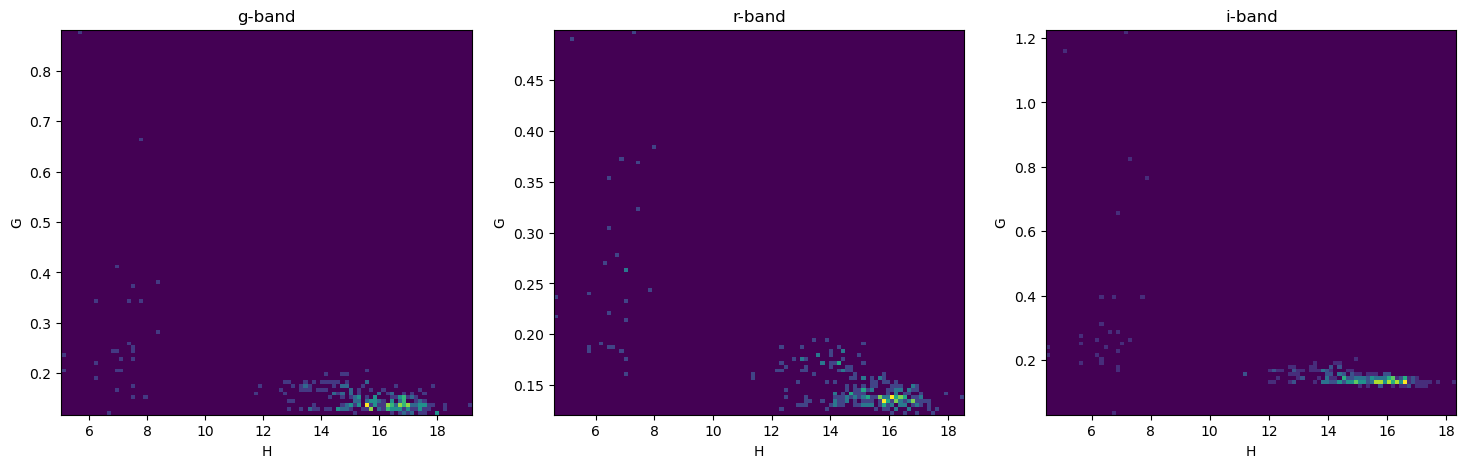

In [14]:
# here we plot the G vs H from the HG model fit (returned above in x_fitted) for the g, r, and i bands
plt.figure(figsize=(18,5))

plt.subplot(131)
h = plt.hist2d(results[results.fname=='g']['HG.H'], results[results.fname=='g']['HG.G'], bins=100)
plt.title('g-band')
plt.xlabel('H')
plt.ylabel('G')

plt.subplot(132)
h = plt.hist2d(results[results.fname=='r']['HG.H'], results[results.fname=='r']['HG.G'], bins=100)
plt.title('r-band')
plt.xlabel('H')
plt.ylabel('G')

plt.subplot(133)
h = plt.hist2d(results[results.fname=='i']['HG.H'], results[results.fname=='i']['HG.G'], bins=100)
plt.title('i-band')
plt.xlabel('H')
plt.ylabel('G')

Text(0.5, 1.0, 'ssObjectId = -9160335891119196734')

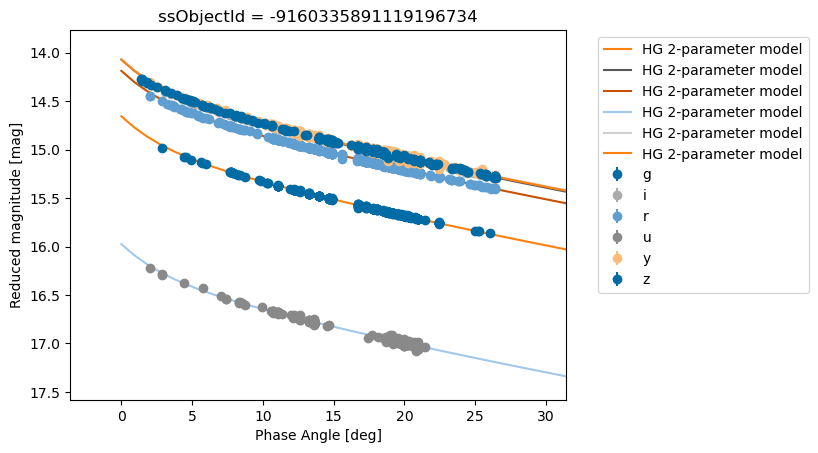

In [15]:
# Plot example phase curve for a single object
sId = df_uniqueObj['ssObjectId'][0]
df_tmp = df_indivObs[df_indivObs['ssObjectId'] == sId]

for ifilt in filts:
    idx = df_tmp['filter'] == ifilt
    
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx], yerr=df_tmp['magSigma'][idx], fmt='o', label=ifilt)

    phases = np.linspace(0,90,100)
    HG_mag = HG_model(np.deg2rad(phases),
                     [results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG.H'].values,
                      results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG.G'].values])
    # HG12_mag = HG12_model(np.deg2rad(phases), [x['HG12']['H'], x['HG12']['G12']])
    # HG_mag = HG_model(np.deg2rad(phases), [x['HG']['H'], x['HG']['G']])
    # HG1G2_mag = HG1G2_model(np.deg2rad(phases), [x['HG1G2']['H'], x['HG1G2']['G1'], x['HG1G2']['G2']])

    plt.plot(phases, HG_mag, label ='HG 2-parameter model')
    
plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)

Text(0.5, 1.0, 'ssObjectId = -9104426139280684352')

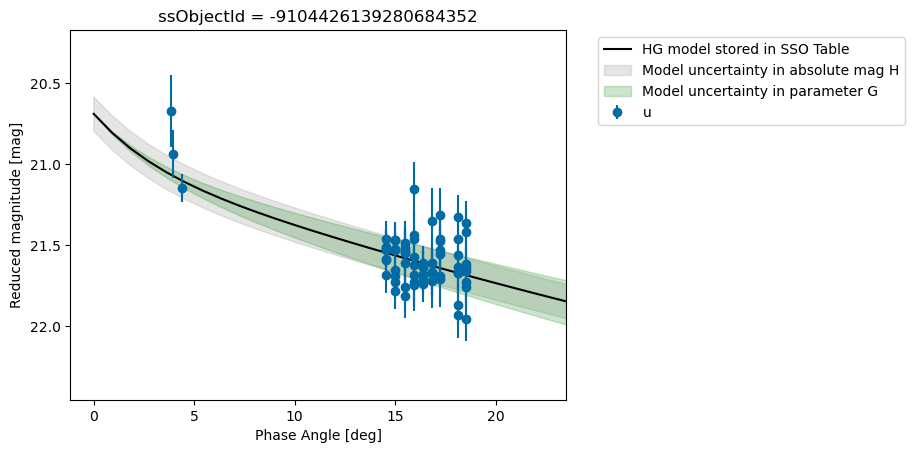

In [16]:
# experiment with plotting error ranges
# df_uniqueObj contains the model params and errors
# df_tmp is the table of obs for just the first object in df_indivObs

# pick a source with lower S/N than the last cell, to demonstrate larger/visible uncertainty range
x = 2
sId = df_uniqueObj['ssObjectId'][x]
df_tmp = df_indivObs[df_indivObs['ssObjectId'] == sId]

# pick a filter with poor S/N to demonstrate fit uncertainty
ifilt = 'u'
idx = df_tmp['filter'] == ifilt


plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx], yerr=df_tmp['magSigma'][idx],
             fmt='o', label=ifilt, zorder=10)


# grab the corresponding model that is already in SSObject Table
# (remarkably, one can add strings inside the header!):
HG_mag_sso = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][x], df_uniqueObj[ifilt+'G12'][x]])
plt.plot(phases, HG_mag_sso, color='k',label ='HG model stored in SSO Table')


# plot the uncertainty ranges:
HG_mag_sso_Hup = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][x]+df_uniqueObj[ifilt+'Herr'][x], 
                                              df_uniqueObj[ifilt+'G12'][x]])

HG_mag_sso_Hlow = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][x]-df_uniqueObj[ifilt+'Herr'][x], 
                                              df_uniqueObj[ifilt+'G12'][x]])

HG_mag_sso_Gup = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][x], 
                                              df_uniqueObj[ifilt+'G12'][x]+df_uniqueObj[ifilt+'G12err'][x]])

HG_mag_sso_Glow = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][x], 
                                              df_uniqueObj[ifilt+'G12'][x]-df_uniqueObj[ifilt+'G12err'][x]])


# plot the bounds of uncertainty in model fit as regions. Illustrative to see the
# parameter separately, perhaps consider taking max of each region at each phase angle 
# in final version.
plt.fill_between(phases, HG_mag_sso_Hlow, HG_mag_sso_Hup, color='gray', alpha=.2,
                 label='Model uncertainty in absolute mag H')
plt.fill_between(phases, HG_mag_sso_Glow, HG_mag_sso_Gup, color='green', alpha=.2,
                label='Model uncertainty in parameter G')


plt.xlim(df_tmp['phaseAngle'][idx].min()-5, df_tmp['phaseAngle'][idx].max()+5)
plt.ylim(df_tmp['reducedMag'][idx].max()+0.5, df_tmp['reducedMag'][idx].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)



#### 2.4.1 Brainstorming additional parameters to use for characterizing the measurements 
These parameters could be useful for the end of section 3, where we explore what measurements we can use that are in df_indivObs and storing a "quality" parameter for them in a new column of df_uniqObj. 

Some ideas to compare uncertainties to (just pick a couple good informative ones): 
- number of observations (done)
- arc (done)
- sso.zNdata (or other filters) = number of datapoints used to fit phase curve (per filter; perhaps less noisy than total number of obs; done)
- Pick mean or median apparent mag photometric uncertainty for the best 68% of measurements? (done)
- mean or median reduced mag uncertainty for best 68% of measurements? (TBD)
- sso.MOID = minimum orbit intersection distance to earth (farther at fixed size means potentially it will stay faint always?) Pedro suggests this will not be a useful metric as it will change a lot and won't be included in 2nd DP0.3 release.
- Pick some median dia.snr = signal to noise ratio at which the source was detected in difference image (TBD)

## 3. Population study of measurements of the SS objects DP0.3 tables 

Now that we have demonstrated how to fit a phase curve to DP0.3 data, experimented with 3 different models, and compared those to the automated fits that are stored in the SSObject Table, we look at the population in aggregate: population study with the fit results (e.g., how the fit values differ due to number of observations, or for near/far or bright/faint objects).

In [ ]:
# First, re-query for a table of columns for unique objects with number of observations and arc over larger
# dynamic range than before, and add some extra criteria of use in assessing uncertainty. To decide: is
# this second query is necessary, or should we adapt the earlier query and sub-sample it with 
# nobs_thrh and arc_thrh >3000, since the query takes a long time (~5 min).

nobs_thrh = 50 
arc_thrh = 100

query = """
SELECT 
    mpc.ssObjectId, mpc.q, sso.arc, sso.numObs, 
    sso.uH, sso.uHerr, sso.uG12, sso.uG12err, 
    sso.gH, sso.gHerr, sso.gG12, sso.gG12err, 
    sso.rH, sso.rHerr, sso.rG12, sso.rG12err, 
    sso.iH, sso.iHerr, sso.iG12, sso.iG12err, 
    sso.zH, sso.zHerr, sso.zG12, sso.zG12err, 
    sso.yH, sso.yHerr, sso.yG12, sso.yG12err,
    sso.uNdata, sso.gNdata, sso.rNdata, 
    sso.iNdata, sso.zNdata, sso.yNdata
FROM 
    dp03_catalogs.MPCORB as mpc 
INNER JOIN dp03_catalogs.SSObject as sso 
ON mpc.ssObjectId = sso.ssObjectId 
WHERE sso.numObs > {} AND sso.arc > {} ORDER by sso.ssObjectId 
""".format(nobs_thrh, arc_thrh)

df_uniqueObj2 = service.search(query).to_table()
df_uniqueObj2

### 3.1 First exploration based on numObs (total number) and arc (total baseline in days) of LSST observations

First, we have a look at how phase curve modeling accuracy might depend on "global" measurements (across all filters). For this section we compare total number of observations for a given source (numObs) and the total time baseline across which observations are made (arc of LSST observations) and explore whether or not these factors impact the quality of phase curve modeling. In general, the first plot shows that more observations yields lower uncertainties in the model fits. I have to admit I don't totally understand the second plot comparing uncertainties as a function of time baseline of observations (arc). I am guessing that longer arc does not translate directly to lower uncertainties, since most(?) of the objects in the catalog are distant (fewer sources close to sun?). Since distant objects can have quite long orbits, perhaps the requisite arc for a good fit varies substantially within the population? Maybe this plot would yield better results if the comparison is made after the sample is grouped by heliocentric distance or something.

In [ ]:

plt.plot(df_uniqueObj2['numObs'], df_uniqueObj2['iHerr'],'.',alpha=.1,label='i-band abs mag H')
plt.plot(df_uniqueObj2['numObs'], df_uniqueObj2['iG12err'],'.',alpha=.1, label='i-band phase angle G')

plt.xlabel('Number of LSST observations')
plt.ylabel(' uncertainty in phase curve fit parameter')
plt.yscale('log')
plt.legend()
plt.show()
plt.plot(df_uniqueObj2['arc'], df_uniqueObj2['iHerr'],'.',alpha=.1,label='i-band abs mag H')
plt.plot(df_uniqueObj2['arc'], df_uniqueObj2['iG12err'],'.',alpha=.1, label='i-band phase angle G')
plt.yscale('log')
plt.xlabel('arc of LSST observations [days]')
plt.ylabel(' uncertainty in phase curve fit parameter')
plt.legend()

## 3.2 Number of data used per band

The above plots compare numObs (total) with model fits (per band) which may not be the ideal metric since as one can see from the modeling of individual objects in different filters in Section 2.4, the quality of phase curves can vary quite a bit between filters. Instead, we can look at the number of datapoints included in the phase curve modeling on a per filter basis (i.e. rNdata for the r-band in the SSObject Table). Below, we look at the distribution of the number of observations in each filter used to model the phase curve per filter for all SSObjects which in total have more than 100 numObs and arc (as per query above). One can see that generally, r and i bands produce the most data points for recovering phase curves, while u-band produces the fewest. In the second plot, one can see that the 

In [ ]:
# first plot histograms to see what the observations look like:

plt.hist(df_uniqueObj2['rNdata'],bins=80,alpha=.8,label='r-band data')
plt.hist(df_uniqueObj2['iNdata'],bins=100,alpha=.4,color='orange',label='i-band data')

plt.hist(df_uniqueObj2['yNdata'],bins=100,alpha=.6,color='magenta',label='y-band data')
plt.hist(df_uniqueObj2['zNdata'],bins=100,alpha=.7,color='r',label='z-band data')
plt.hist(df_uniqueObj2['gNdata'],bins=100,alpha=.8,color='green',label='g-band data')
plt.hist(df_uniqueObj2['uNdata'],bins=100,alpha=.9,color='blue',label='u-band data')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of data points per filter')
plt.ylabel('Number of sources')
plt.show()


# maybe this needs to be a density plot?
plt.plot(df_uniqueObj2['rNdata'], 100*df_uniqueObj2['rHerr']/df_uniqueObj2['rH'],'.',alpha=.1,label='r-band abs mag')
plt.plot(df_uniqueObj2['uNdata'], 100*df_uniqueObj2['uHerr']/df_uniqueObj2['uH'],'.',alpha=.1,label='u-band abs mag')
plt.xlabel('Number of data points per filter')
plt.ylabel('Fractional Uncertainty [%]')
plt.legend()

#plt.plot(df_uniqueObj2['rNdata'], df_uniqueObj2['rG12err'],'.',alpha=.1, label='r-band phase angle')
plt.yscale('log')
plt.show()

## 3.3 Typical apparent magnitude uncertainties

Here we compare the typical apparent magnitude uncertainties per band to see how that impacts the fit. Is there a good way to do this while avoiding doing a for loop over df_uniqueObj? This for loop over df_uniqueObj is already done earlier in section 2.4, it might be better to move this determination of the magnitude sigma metric there, and append it to df_uniqueObj table for use later.

Finally, the plot shows that median photometric uncertainty does drive the phase curve model uncertainties. (TBD: should we be plotting fractional uncertainty of model fit in %, or just plain old uncertainty?)

In [ ]:
from astropy.stats import sigma_clip

#df_indivObs['magSigma'] # this is all objects, all observation uncertainties
#df_tmp['magSigma'] # this is one object's all observations uncertainties

magSigma_quality = []

for iobj in df_uniqueObj['ssObjectId']:
    idx = df_indivObs['ssObjectId'] == iobj
    df_tmp = df_indivObs[idx]
    filts = np.unique(df_tmp['filter'])
    #for ifilt in filts:
    ifilt = 'r'
    idx_filt = df_tmp['filter'] == ifilt # pick something with good measurements
    #get median value of the "typical" (middle 68%) of the uncertainties :
    #magSigma_quality.append(np.median(sigma_clip(df_tmp['magSigma'][idx_filt], sigma=1)))
    magSigma_quality.append(np.median(df_tmp['magSigma'][idx_filt]))
df_uniqueObj[ifilt+'magSigma_quality'] = magSigma_quality #stddev of whatever from above
#print(df_uniqueObj)

In [ ]:
#plt.plot(df_uniqueObj['rmagSigma_quality'], 100*df_uniqueObj['rHerr']/df_uniqueObj['rH'],'.',alpha=.5,label='r-band abs mag H')
#plt.plot(df_uniqueObj['rmagSigma_quality'], 100*df_uniqueObj['rG12err']/df_uniqueObj['rG12'],'.',alpha=.5,label='r-band G parameter')
#plt.ylabel('Fractional Uncertainty in phase curve fit [%]')

plt.plot(df_uniqueObj['rmagSigma_quality'], df_uniqueObj['rHerr'],'.',alpha=.5,label='r-band abs mag H')
plt.plot(df_uniqueObj['rmagSigma_quality'], df_uniqueObj['rG12err'],'.',alpha=.5,label='r-band G parameter')
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('median uncertainty in apparent mag')

plt.legend()

plt.show()

## Junk Code Below

In [ ]:
# Object from Meg's notebook: -9223369546614897710
#ssObjId = df0['ssObjectId'] 

# diaObjectId is the ID that links the individual measurements between DiaObject and SSSource,
# so you have to match on this id for unique measurement matching. 
# To then match this object to MPCORB and SSObject, you have
# to link on the SSObjectID (hwich is unique per solar system object)

# query = "SELECT dia.diaSourceId, sss.diaSourceId, dia.mag, " + \
#         "dia.magSigma, dia.filter, sss.phaseAngle, sss.topocentricDist, " + \
#         "sss.heliocentricDist, dia.midPointTai " + \
#         "FROM dp03_catalogs.DiaSource as dia " + \
#         "JOIN dp03_catalogs.SSSource as sss " + \
#         "ON dia.diaSourceId = sss.diaSourceId " + \
#         "WHERE dia.ssObjectId IN {} ORDER by sss.diaSourceId".format(tuple(df0['ssObjectId']))


# df = service.search(query).to_table()
# df